# SSD++ vs. my method

In [1]:
import pandas as pd

import capnp
capnp.remove_import_hook()
interface_capnp = capnp.load("../../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

import sys
sys.path.append("../..")
from experiments.evaluation import Evaluator
from experiments.modelgeneration import ModelGenerator

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /root/.vscode-server/bin/b7886d7461186a5eac768481578c1d7ca80e2d21


In [2]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdatesCpp = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [3]:
client = capnp.TwoPartyClient("ssdpp:21652")
processDataUpdatesSsdpp = client.bootstrap().cast_as(interface_capnp.SimpleProcessDataUpdates)

In [4]:
# initialize objects
evaluator = Evaluator(interface_capnp, processDataUpdatesCpp)
modelGen = ModelGenerator(interface_capnp, processDataUpdatesCpp, processDataUpdatesSsdpp)

In [5]:
metricsCat = ["complexity", "valueSetF1"]
metricsNum = ["complexity", "predictionMAE", "predictionRMSE"]

## Individual test

### Generate event log

In [5]:
!capnp convert json:binary ../../cpp-tool/capnproto/interface.capnp RuleModel < SSDppModel.json > /tmp/SSDppModel.bin
with open("/tmp/SSDppModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdatesCpp.modelToString(model).wait().string)

IF light = red THEN color IN {blue}
IF 70.000000 <= length THEN speed = 42.000000
IF length <= 25.000000 THEN speed = 11.000000
IF 50.000000 <= speed THEN color IN {orange}
IF light = green THEN length = 60.000000



In [6]:
logWithUsage = processDataUpdatesCpp.generateEventLog(model=model, numberOfTraces=50, traceLength=10).wait()
log = logWithUsage.log
ruleUsage = logWithUsage.ruleUsage

In [7]:
updateRules = [x.rule.updateRule for x in ruleUsage]
frequencies = [x.frequency for x in ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "speed",\n  valueRule = (constant...        104
1  ( variable = "color",\n  valueSetRule = (set =...        160
2  ( variable = "speed",\n  valueRule = (constant...         88
3  ( variable = "color",\n  valueSetRule = (set =...        135
4  ( variable = "length",\n  valueRule = (constan...        163

### Add noise

In [8]:
from experiments.addnoise import addSwapNoiseToMessage
noisyLog = addSwapNoiseToMessage(log, proportion=0.1)

Constructing traces: 100%|██████████| 50/50 [00:00<00:00, 2329.94it/s]


### Find model with my method

In [9]:
cppModel = processDataUpdatesCpp.findModel(noisyLog).wait().model
print(processDataUpdatesCpp.modelToString(cppModel).wait().string)

IF light = red THEN color IN {blue}
IF light = green THEN length = 60.000000
IF length <= 25.900000 THEN speed = 11.000000
IF 50.200000 <= speed THEN color IN {orange}
IF 71.200000 <= length THEN speed = 42.000000



### Find model with SSD++

In [10]:
ssdppModel = processDataUpdatesSsdpp.findModel(noisyLog).wait().model
ssdppModel = modelGen.removeCyclicRules(ssdppModel)
print(processDataUpdatesCpp.modelToString(ssdppModel).wait().string)

IF (light = green) AND (45.800000 <= speed) THEN color IN {orange}
IF (light = red) AND (74.800000 <= length) THEN color IN {blue}
IF (speed <= 45.800000) AND ((11.000000 <= speed) AND ((light = red) AND (length <= 60.000000))) THEN color IN {blue}
IF (light = yellow) AND (76.050000 <= speed) THEN color IN {orange}
IF (light = yellow) AND ((speed <= 42.000000) AND (11.000000 <= speed)) THEN color IN {black}
IF light = red THEN color IN {blue}
IF (speed <= 45.800000) AND (11.000000 <= speed) THEN color IN {blue}
IF (light = green) AND ((speed <= 45.800000) AND (26.550000 <= speed)) THEN length = 60.470833
IF (light = green) AND (speed <= 11.000000) THEN length = 60.707143
IF (light = yellow) AND ((speed <= 45.800000) AND (42.000000 <= speed)) THEN length = 81.322917
IF (light = green) AND (26.550000 <= speed) THEN length = 57.937179
IF (light = yellow) AND ((speed <= 26.550000) AND (11.000000 <= speed)) THEN length = 28.718750



## Generate random models

In [11]:
models = modelGen.generateTrueModels(numberOfModels=4, numberOfRules=5, catVariablesCount=2,
                                     numVariablesCount=2, valuesPerCatVariable=4)
for model in models:
    print(processDataUpdatesCpp.modelToString(model).wait().string)
    print("====================")

IF a = C THEN b = 87.000000
IF a = D THEN b = 48.600000
IF c <= 86.000000 THEN b = 75.200000
IF a = B THEN d IN {C}
IF a = A THEN d IN {A}

IF a = D THEN d = 64.300000
IF c <= 70.300000 THEN a IN {D}
IF c <= 2.300000 THEN b IN {B}
IF a = C THEN b IN {A}
IF a = B THEN d = 74.400000

IF c <= 58.300000 THEN d = 40.600000
IF 44.000000 <= d THEN a IN {B}
IF b = A THEN a IN {D}
IF c <= 13.100000 THEN d = 28.700000
IF 83.200000 <= c THEN d = 55.100000

IF c = C THEN a = 10.900000
IF d = C THEN c IN {C}
IF a <= 60.900000 THEN b = 39.600000
IF d = D THEN c IN {D}
IF d = A THEN a = 60.800000



## Evaluating experiments

In [6]:
noiseTableCat = evaluator.createExperimentTable("ssdppNoiseVariationCategorical",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-(.+)-model\.bin",
    ["noiseProportion", "logLength", "modelID", "logVariant", "method"])
samplesTableCat = evaluator.createExperimentTable("ssdppSampleVariationCategorical",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-(.+)-model\.bin",
    ["noiseProportion", "logLength", "modelID", "logVariant", "method"])
noiseTableNum = evaluator.createExperimentTable("ssdppNoiseVariationNumerical",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-(.+)-model\.bin",
    ["noiseProportion", "logLength", "modelID", "logVariant", "method"])
samplesTableNum = evaluator.createExperimentTable("ssdppSampleVariationNumerical",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-(.+)-model\.bin",
    ["noiseProportion", "logLength", "modelID", "logVariant", "method"])

In [7]:
evaluator.addMetricsToExperimentTable("ssdppNoiseVariationCategorical", noiseTableCat, metricsCat)
evaluator.addMetricsToExperimentTable("ssdppSampleVariationCategorical", samplesTableCat, metricsCat)
evaluator.addMetricsToExperimentTable("ssdppNoiseVariationNumerical", noiseTableNum, metricsNum)
evaluator.addMetricsToExperimentTable("ssdppSampleVariationNumerical", samplesTableNum, metricsNum)

Computing predictionRMSE: 100%|██████████| 1020/1020 [01:22<00:00, 12.29it/s]


In [8]:
noiseTableCat.to_csv("ssdppNoiseTableCat.csv")
samplesTableCat.to_csv("ssdppSamplesTableCat.csv")
noiseTableNum.to_csv("ssdppNoiseTableNum.csv")
samplesTableNum.to_csv("ssdppSamplesTableNum.csv")

## Visualizing experiments

In [9]:
noiseTableCat = pd.read_csv("ssdppNoiseTableCat.csv")
samplesTableCat = pd.read_csv("ssdppSamplesTableCat.csv")
noiseTableNum = pd.read_csv("ssdppNoiseTableNum.csv")
samplesTableNum = pd.read_csv("ssdppSamplesTableNum.csv")

In [10]:
# fix datatypes
noiseTableCat.logLength = pd.to_numeric(noiseTableCat.logLength)
noiseTableCat.noiseProportion = pd.to_numeric(noiseTableCat.noiseProportion)
samplesTableCat.logLength = pd.to_numeric(samplesTableCat.logLength)
samplesTableCat.noiseProportion = pd.to_numeric(samplesTableCat.noiseProportion)

noiseTableNum.logLength = pd.to_numeric(noiseTableCat.logLength)
noiseTableNum.noiseProportion = pd.to_numeric(noiseTableCat.noiseProportion)
samplesTableNum.logLength = pd.to_numeric(samplesTableCat.logLength)
samplesTableNum.noiseProportion = pd.to_numeric(samplesTableCat.noiseProportion)

In [11]:
# aggregate data for plot
aggregationColumns = ["logLength", "noiseProportion", "method"]

noiseCatAggregated = evaluator.aggregateMetrics(noiseTableCat, aggregationColumns, metricsCat)
samplesCatAggregated = evaluator.aggregateMetrics(samplesTableCat, aggregationColumns, metricsCat)

noiseNumAggregated = evaluator.aggregateMetrics(noiseTableNum, aggregationColumns, metricsNum)
samplesNumAggregated = evaluator.aggregateMetrics(samplesTableNum, aggregationColumns, metricsNum)

### Plots

#### Categorical target

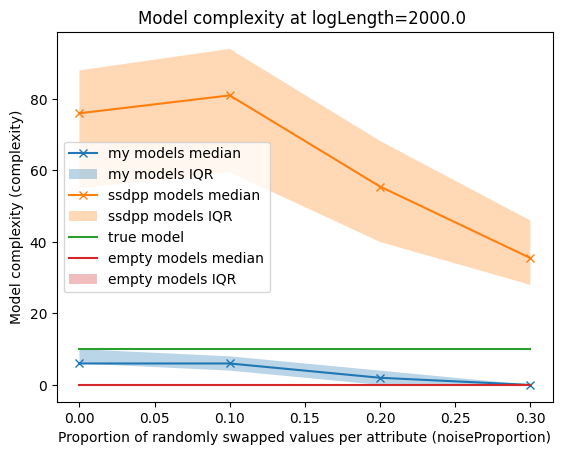

In [12]:
evaluator.plotScoreWithIqr(noiseCatAggregated, "complexity", "noiseProportion", ["logLength"],
                           ["my", "ssdpp", "true", "empty"])

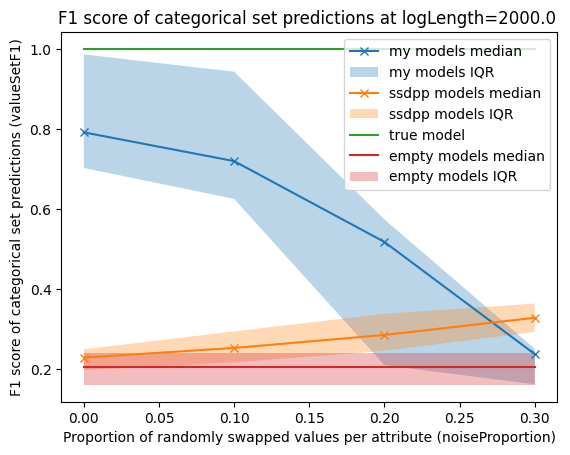

In [13]:
evaluator.plotScoreWithIqr(noiseCatAggregated, "valueSetF1", "noiseProportion", ["logLength"],
                           ["my", "ssdpp", "true", "empty"])

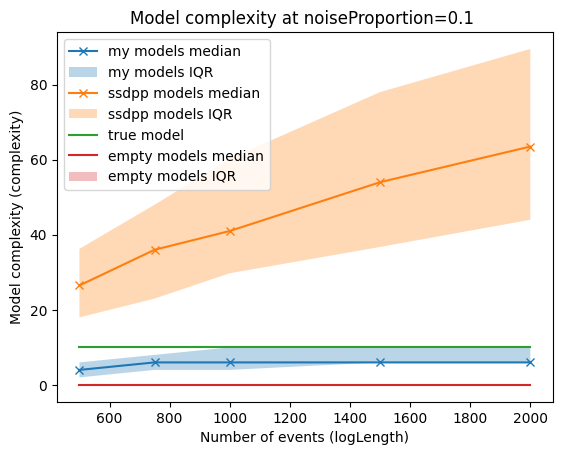

In [14]:
evaluator.plotScoreWithIqr(samplesCatAggregated, "complexity", "logLength", ["noiseProportion"],
                           ["my", "ssdpp", "true", "empty"])

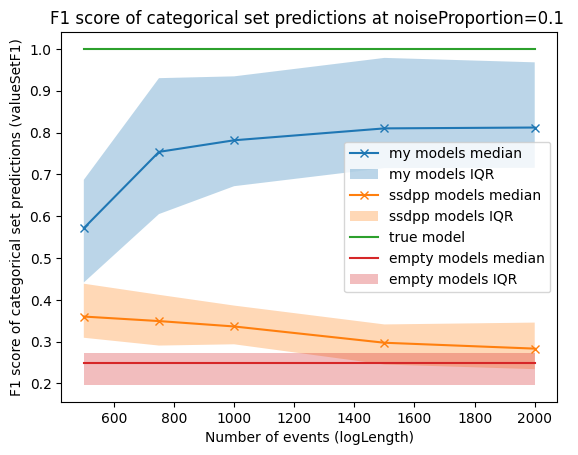

In [15]:
evaluator.plotScoreWithIqr(samplesCatAggregated, "valueSetF1", "logLength", ["noiseProportion"],
                           ["my", "ssdpp", "true", "empty"])

#### Numerical target

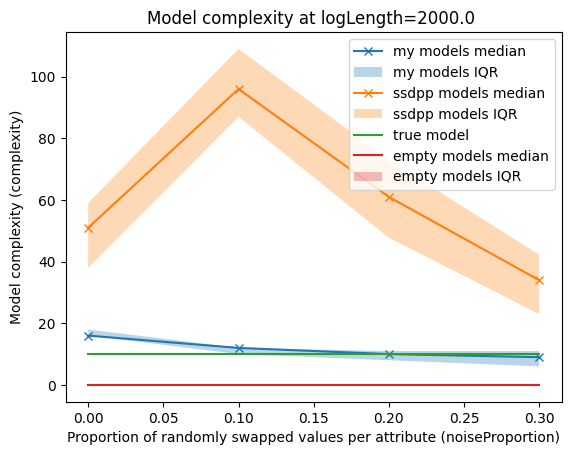

In [16]:
evaluator.plotScoreWithIqr(noiseNumAggregated, "complexity", "noiseProportion", ["logLength"],
                           ["my", "ssdpp", "true", "empty"])

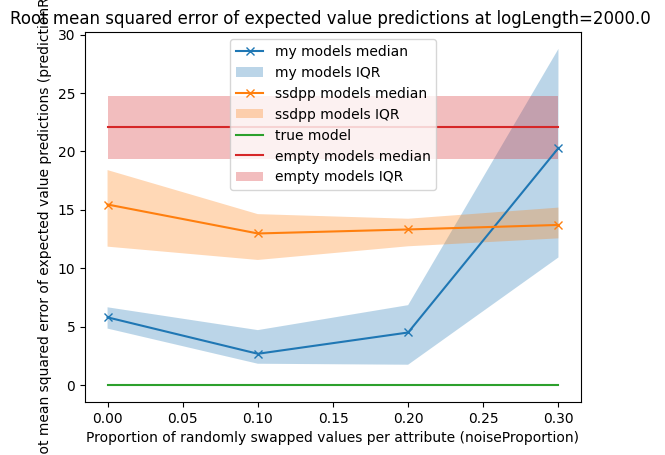

In [17]:
evaluator.plotScoreWithIqr(noiseNumAggregated, "predictionRMSE", "noiseProportion", ["logLength"],
                           ["my", "ssdpp", "true", "empty"])

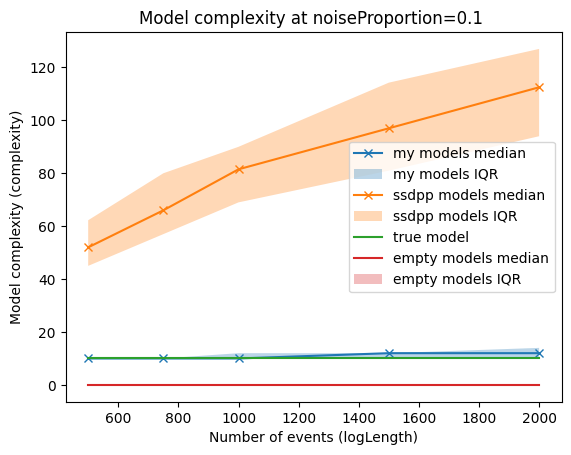

In [18]:
evaluator.plotScoreWithIqr(samplesNumAggregated, "complexity", "logLength", ["noiseProportion"],
                           ["my", "ssdpp", "true", "empty"])

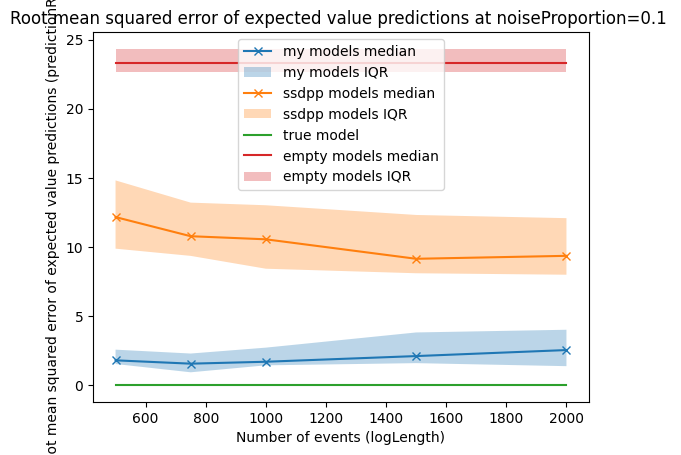

In [19]:
evaluator.plotScoreWithIqr(samplesNumAggregated, "predictionRMSE", "logLength", ["noiseProportion"],
                           ["my", "ssdpp", "true", "empty"])

### LaTeX exports

In [20]:
def extractMetricForPgfplots(aggregatedTable, metricName, fileName):
    metric = aggregatedTable[metricName]
    metric = metric.drop([0.4, 0.5], level=1, axis="index", errors="ignore")
    metric["lowIqr"] = metric["midIqr"] - metric["lowIqr"]
    metric["highIqr"] = metric["highIqr"] - metric["midIqr"]
    metric = metric.rename(columns={"lowIqr": "relative lowIqr", "highIqr": "relative highIqr"})
    metric.to_csv("../../document/figs/" + fileName)

In [21]:
extractMetricForPgfplots(noiseCatAggregated, "valueSetF1", "prediction-f1-noise-vs-ssdpp.csv")

In [22]:
extractMetricForPgfplots(noiseNumAggregated, "predictionRMSE", "prediction-rmse-noise-vs-ssdpp.csv")

In [23]:
# plot complexity for categorical and numerical experiments together
jointComplexity = pd.concat([noiseTableCat, noiseTableNum])
jointComplexity = jointComplexity.drop(["Unnamed: 0", "filename", "valueSetF1", "predictionMAE",
                                        "predictionRMSE"], axis="columns")
jointComplexity = evaluator.aggregateMetrics(jointComplexity, aggregationColumns, ["complexity"])
extractMetricForPgfplots(jointComplexity, "complexity", "complexity-noise-vs-ssdpp.csv")

## Tweaking other parameters

In [5]:
emptyModel = interface_capnp.RuleModel.new_message(rules=[], variables=[])
model = modelGen.generateTrueModels(numberOfModels=1, numberOfRules=5, catVariablesCount=2,
                                    numVariablesCount=2, valuesPerCatVariable=4, targetType="numerical")[0]
testLog = processDataUpdatesCpp.generateEventLog(model, 200, 10).wait().log
print(processDataUpdatesCpp.modelToString(model).wait().string)

IF 80.800000 <= d THEN a = 6.300000
IF 27.700000 <= d THEN a = 2.100000
IF b = C THEN d = 71.800000
IF b = A THEN d = 86.900000
IF d <= 89.700000 THEN a = 4.800000



In [6]:
evaluator.computeMetric("valueSetF1", model, model, testLog)

1.0

In [7]:
evaluator.computeMetric("valueSetF1", emptyModel, model, testLog)

1.0

In [8]:
evaluator.computeMetric("predictionMAE", model, model, testLog)

0.0

In [9]:
evaluator.computeMetric("predictionMAE", emptyModel, model, testLog)

30.1759625